In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [237]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
# Use Tensorboard for network visualization & debugging
from tensorflow.keras.callbacks import TensorBoard
import sklearn.metrics
# import regularizer(s)
from tensorflow.keras.regularizers import l1, l2, l1_l2
# import Dropout
from tensorflow.keras.layers import Dropout
# import activation seperately
from tensorflow.keras.layers import Activation

In [238]:
import warnings

#ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [239]:
V52_data = pd.read_csv('V52_data_process.csv')
# make Date the index in datetime format
V52_data.index = pd.to_datetime(V52_data['Date'], format='%Y%m%d%H%M')

data_AS03 = pd.read_csv('WindData_AS03.csv')
# make Date the index in datetime format
data_AS03.index = pd.to_datetime(data_AS03['date_time'], format='%Y-%m-%d %H:%M:%S')

V52_data['ActPow'].describe()

count    37043.000000
mean       199.218650
std        215.220716
min          1.052640
25%         49.857800
50%        112.711000
75%        259.903500
max        867.900000
Name: ActPow, dtype: float64

## With a continous data set we can begin a LSTM model

## Additional info on the time series processing - things to watch out!
1. **Non-stationary data** 
<br>‘Stationarity’ is one of the most important concepts you will come across when working with time series data. A stationary series is one in which the properties – mean, variance and covariance, **do not** vary with time.
<br>  Always keep in mind that in order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first. There are mainly two ways to do this:
     <br> 1.1 ***Differencing (one or multiple steps)***   $\rightarrow y_{diff}=y_{t}-y_{t-n} $ Pandas diff can directly be used or you can use df.shift(n) to extract $y_{t-n}$ 
     <br> 1.2 ***Axis transformations*** $\rightarrow$ e.g. log-transform can also help depending on your data. Also note that you can repeat the differencing several times until you reach the 'desired' stationarity.
2. **Scaling**
<br>As discussed (and demonstrated) above.
3. **LSTM particular input shape**
<br> Think thorough on samples, timesteps, features and what they represent for your data and problem at hand. In general, it goes as "how many features you would like to feed into the model at a time (timesteps) and how many of those sequences do you have? Let's do an example for our forecasting problem at hand...
3. **Inverse transform the output**
<br> Different than 'just' a binary classification, the output of your model might have units and non-stationary structure as well. Remember to inverse transform of your model predictions to deliver the 'true value' of your outputs.

## Divide Time series into Sequences
We will define 2 useful functions that will generate sequences of input + output intervals.

* The input interval is based on how much further back you would like to add to the memory
* The output interval depends on the forecast horizon for your problem


The input interval is one of the *hyperparameters* to tune. We can start with an initial guess and adjust it to see if we can get a performance increase.

In [240]:
### define a function that will prepare the shifting input sequences for the network
def forecast_sequences_input(input_data, n_lag):
    """
    A function that will split the input time series to sequences for nowcast/forecast problems
    Arguments:
        input_data: Time series of input observations as a list, NumPy array or pandas series
        n_lag: number of previous time steps to use for training, a.k.a. time-lag        
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = input_data.shape[1] 
    df = pd.DataFrame(input_data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


### define a function that will prepare the shifting output sequences of the network
def forecast_sequences_output(output_data,n_out):
    """
    A function that will split the output time series to sequences for nowcast/forecast problems
    Arguments:
        output_data: Time series of input observations as a list, NumPy array or pandas series
        n_out: forecast horizon (for multi-output forecast)
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = output_data.shape[1] 
    df = pd.DataFrame(output_data)
    cols, names = list(), list()
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names    
    return agg


### Define length of the input and output intervals within the sequences

In [241]:
n_lag = 36 # number of previous time steps to use for training, a.k.a. time-lag
n_out = 6  # forecast hoizon: number of next time steps we will predict 1 = the next 10-min mean

### Define training, validation and test data as before, let's use dataframes this time
INPUTS:   
   1. Power
   2. std of power

OUTPUT:
   1. future power 


Sequence creation

In [242]:
### Split data into train & test 
train_int = int(0.6*len(V52_data))      # 60% of the data length for training
validation_int = int(0.8*len(V52_data)) # 20% more for validation

# training input vector
X_train = V52_data[['ActPow']][:train_int]
X_train = forecast_sequences_input(X_train ,n_lag)

# training output vector
Y_train = V52_data[['ActPow']][:train_int]
Y_train = forecast_sequences_output(Y_train, n_out)

# validation input vector
X_validation = V52_data[['ActPow']][train_int:validation_int]
X_validation = forecast_sequences_input(X_validation,n_lag)

# validation output vector
Y_validation = V52_data[['ActPow']][train_int:validation_int]
Y_validation = forecast_sequences_output(Y_validation, n_out)

# test input vector
X_test = V52_data[['ActPow']][validation_int:]
X_test = forecast_sequences_input(X_test,n_lag)

# test output vector
Y_test = V52_data[['ActPow']][validation_int:]
Y_test = forecast_sequences_output(Y_test, n_out)

In [243]:
X_train

,var1(t-36),var1(t-35),var1(t-34),var1(t-33),var1(t-32),var1(t-31),var1(t-30),var1(t-29),var1(t-28),var1(t-27),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.6673
2018-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.6673,70.8152
2018-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.6673,70.8152,80.8037
2018-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,64.6673,70.8152,80.8037,86.1123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-07 23:10:00,249.581,279.778,193.456,404.387,241.783,135.362,224.015,93.718,225.743,203.734,...,188.676,224.115,187.164,198.042,230.832,264.180,243.6690,211.0140,175.0950,209.5140
2018-08-07 23:20:00,279.778,193.456,404.387,241.783,135.362,224.015,93.718,225.743,203.734,238.245,...,224.115,187.164,198.042,230.832,264.180,243.669,211.0140,175.0950,209.5140,232.8220
2018-08-07 23:30:00,193.456,404.387,241.783,135.362,224.015,93.718,225.743,203.734,238.245,240.180,...,187.164,198.042,230.832,264.180,243.669,211.014,175.0950,209.5140,232.8220,220.9390


In [244]:
Y_train

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
Date,,,,,,
2018-01-01 00:00:00,64.6673,70.8152,80.8037,86.1123,110.8570,106.1850
2018-01-01 00:10:00,70.8152,80.8037,86.1123,110.8570,106.1850,60.0936
2018-01-01 00:20:00,80.8037,86.1123,110.8570,106.1850,60.0936,39.2994
2018-01-01 00:30:00,86.1123,110.8570,106.1850,60.0936,39.2994,45.9785
2018-01-01 00:40:00,110.8570,106.1850,60.0936,39.2994,45.9785,69.2233
...,...,...,...,...,...,...
2018-08-07 23:10:00,232.8220,220.9390,206.5300,169.3650,145.8480,NaN
2018-08-07 23:20:00,220.9390,206.5300,169.3650,145.8480,NaN,NaN
2018-08-07 23:30:00,206.5300,169.3650,145.8480,NaN,NaN,NaN


## PREPROCESSING OF THE DATA IS NEEDED BECASUE THE NANS IN THE OUTPUT ARE NOT ALLOWED

Preporcessing of training data

In [245]:
# find and store the indices where there is a nNan in Y_train
nan_index_y = np.where(np.isnan(Y_train['var1(t)']))[0] #this is the present t (which will be pedicted by the previous time stamps)
# we need to remove the corresponding rows in Y_train at t
Y_train = Y_train.drop(Y_train.index[nan_index_y])
# regarding the next timesteps, we also need to remove last rows diagonal which has nans
Y_train = Y_train.drop(Y_train.index[-(n_out-1):]) # to account for tis we will delete the first n_out-1 rows of X_train


# now we need to drop the corresponding rows in X_train
# however the corresponding rows will be shifted by n_lag
nan_index_x = nan_index_y + 1
# remove rows in X_train at index nan_index_x
X_train = X_train.drop(X_train.index[nan_index_x])
# accounting for the n_out-1 rows we removed from Y_train, we will also remove the first n_out-1 rows of X_train
X_train = X_train.drop(X_train.index[(n_lag-n_out+1):(n_lag)])

In [246]:
# how many nans are there in Y_train[var1(t+1)]?
nan_index_y2 = np.where(np.isnan(Y_train['var1(t+1)']))[0] # 207
# what do with this?, if there werent a lot we could eliminte but if we want to predict many hoyrs ex 6 this will be multiplied by 36, too much
# we will perform a fill which is the linear interpolation betwween the previous and next value
Y_train = Y_train.interpolate(method='linear', axis=0).ffill().bfill()

preprocessing of validation data: repeat same as training

In [247]:
nan_y_validation = np.where(np.isnan(Y_validation['var1(t)']))[0]
Y_validation = Y_validation.drop(Y_validation.index[nan_y_validation])

Y_validation = Y_validation.drop(Y_validation.index[-(n_out-1):])

nan_x_validation = nan_y_validation + 1
X_validation = X_validation.drop(X_validation.index[nan_x_validation])

X_validation = X_validation.drop(X_validation.index[(n_lag-n_out+1):(n_lag)])

In [248]:

Y_validation = Y_validation.interpolate(method='linear', axis=0).ffill().bfill()

preprocessing of test data: repeat same as training

In [249]:
nan_y_test = np.where(np.isnan(Y_test['var1(t)']))[0]
#Y_test = Y_test.dropna() # I DONT DROP THEM BC I WANT TO SEE HOE THE MODEL REACTS TO NANs
Y_test = Y_test.drop(Y_test.index[-(n_out-1):])

nan_x_test = nan_y_test + 1
#X_test = X_test.drop(X_test.index[nan_x_test]) # I DONT DROP THEM BC I WANT TO SEE HOE THE MODEL REACTS TO NANs
X_test = X_test.drop(X_test.index[(n_lag-n_out+1):(n_lag)])

### Remember to scale!

In [250]:
from sklearn.preprocessing import MinMaxScaler
### scale the dataset
scalerx = MinMaxScaler(feature_range=(0, 1))
scalery = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scalerx.fit_transform(X_train)
X_validation_scaled = scalerx.transform(X_validation)
X_test_scaled = scalerx.transform(X_test)

Y_train_scaled = scalery.fit_transform(Y_train)
Y_validation_scaled = scalery.transform(Y_validation)
Y_test_scaled = scalery.transform(Y_test)

print('Training input (samples, timesteps):', X_train_scaled.shape)
print('Training output (samples, timesteps):', Y_train.shape)
print('Validation input (samples, timesteps):', X_validation_scaled.shape)
print('Validation output (samples, timesteps):', Y_validation.shape)


Training input (samples, timesteps): (21986, 36)
Training output (samples, timesteps): (21986, 6)
Validation input (samples, timesteps): (8159, 36)
Validation output (samples, timesteps): (8159, 6)


### Pad NaNs for missing periods with a significant number (to be 'masked' for the training later)

In [251]:
pad_value = 999

X_train_scaled[np.isnan(X_train_scaled)] = pad_value
X_validation_scaled[np.isnan(X_validation_scaled)] = pad_value
#X_test_scaled[np.isnan(X_test_scaled)] = pad_value

# I have dropped the nans so these are not useful anaymore,### though what about the last rows?
#Y_train_scaled[np.isnan(Y_train_scaled)] = pad_value
#Y_validation_scaled[np.isnan(Y_validation_scaled)] = pad_value
#Y_test_scaled[np.isnan(Y_test_scaled)] = pad_value

In [252]:
X_train_scaled

array([[9.99000000e+02, 9.99000000e+02, 9.99000000e+02, ...,
        9.99000000e+02, 9.99000000e+02, 9.99000000e+02],
       [9.99000000e+02, 9.99000000e+02, 9.99000000e+02, ...,
        9.99000000e+02, 9.99000000e+02, 7.39320764e-02],
       [9.99000000e+02, 9.99000000e+02, 9.99000000e+02, ...,
        9.99000000e+02, 7.38695090e-02, 8.10770806e-02],
       ...,
       [2.23556064e-01, 4.68713712e-01, 2.79724829e-01, ...,
        2.42219710e-01, 2.69309775e-01, 2.55548881e-01],
       [4.68713712e-01, 2.79724829e-01, 1.56035461e-01, ...,
        2.69309775e-01, 2.55498584e-01, 2.38802941e-01],
       [2.79724829e-01, 1.56035461e-01, 2.59073710e-01, ...,
        2.55498584e-01, 2.38751512e-01, 1.95610293e-01]])

In [253]:
Y_train_scaled

array([[0.07393208, 0.08107708, 0.09268558, 0.09885516, 0.12761311,
        0.12218337],
       [0.08107708, 0.09268558, 0.09885516, 0.12761311, 0.12218337,
        0.06861659],
       [0.09268558, 0.09885516, 0.12761311, 0.12218337, 0.06861659,
        0.04444985],
       ...,
       [0.24401418, 0.20226962, 0.2422709 , 0.26935914, 0.25554888,
        0.23880294],
       [0.20226962, 0.2422709 , 0.26935914, 0.25554888, 0.23880294,
        0.19561029],
       [0.2422709 , 0.26935914, 0.25554888, 0.23880294, 0.19561029,
        0.16827916]])

## LSTM architecture

We will first add a Masking layer to tell the network to ignore missing periods in the training
 
We will use pretty much the same architecture with FFNN, except for the LSTM layers. 

There are however, little differences LSTM requires in bulding the model.

In [254]:
from tensorflow.keras.layers import LSTM, Masking

# for multiple model creation - clear  the previous DAG
K.clear_session() 

### Input reshape for LSTM problem  [samples, timesteps, features]
no_features = 1 # power

train_X = X_train_scaled.reshape((X_train_scaled.shape[0], n_lag, no_features))#.astype('float32')
train_Y = Y_train_scaled #.values#.astype('float32')

validation_X = X_validation_scaled.reshape((X_validation_scaled.shape[0], n_lag, no_features))#.astype('float32')
validation_Y = Y_validation_scaled #.values#.astype('float32')

test_X = X_test_scaled.reshape((X_test_scaled.shape[0], n_lag, no_features))#.astype('float32')
test_Y = Y_test_scaled #.values#.astype('float32')


In [255]:
from keras.callbacks import EarlyStopping
### create model
model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))
#model.add(Masking(mask_value=NanIgnore, input_shape=(None, no_features))) # 0.0011607661 is the pad_value for the scaled -1


# First LSTM layer
model.add(LSTM(50, 
               return_sequences=True,  # important to add it to ensure the following LSTM layers will have the same input shape
               input_shape=(train_X.shape[1], train_X.shape[2]),                
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros'))
               
# then we add the activation
model.add(Activation('tanh'))

# Second LSTM layer
model.add(LSTM(10, activation='tanh'))

# Output Layer
model.add(Dense(1))
model.summary()

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# fit the model and store the graphs and performance to be used in TensorBoard (optional)
now = datetime.datetime.now().strftime("%Y%m%d%H%M")

tbGraph = TensorBoard(log_dir=f'.\Graph\{now}',
                      histogram_freq=64*2, write_graph=True, write_images=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# add it to your callbacks list
callbacks = [tbGraph, early_stopping]

history = model.fit(train_X, train_Y, 
          epochs=15,
          batch_size=1000,
          validation_data=(validation_X, validation_Y),
          callbacks=[tbGraph])




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, None, 50)          10400     
                                                                 
 activation (Activation)     (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                2440      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 12851 (50.20 KB)
Trainable params: 12851 (50.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
22/22 [==

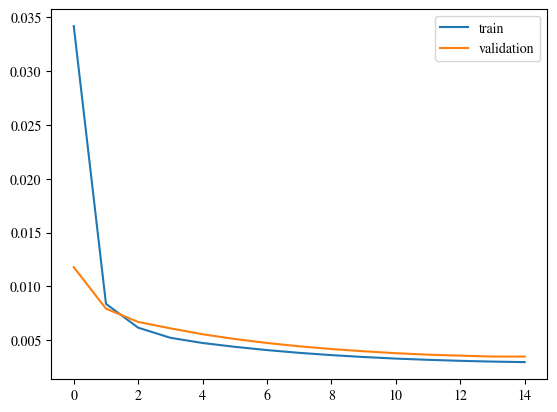

In [256]:
# plot the lost
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.legend()

In [257]:
# Fit a new scaler on the single feature you're predicting
scaler_single = MinMaxScaler()
scaler_single.fit(Y_test['var1(t)'].values.reshape(-1, 1))  # Reshape to 2D array


MinMaxScaler()

In [258]:
# Make predictions and plot them against the actual values
predictions = model.predict(test_X)


329/329 [==============================] - 4s 8ms/step


In [259]:

# Invert the predictions to the original scale
predictions = scaler_single.inverse_transform(predictions)


In [260]:

predictions


array([[      nan],
       [      nan],
       [      nan],
       ...,
       [787.2257 ],
       [760.0376 ],
       [711.52563]], dtype=float32)

In [261]:
test_Y = scalery.inverse_transform(test_Y)
test_Y

array([[ 47.8596,  40.1275,  48.9501,  48.1567,  53.2609,  68.6759],
       [ 40.1275,  48.9501,  48.1567,  53.2609,  68.6759,  49.6674],
       [ 48.9501,  48.1567,  53.2609,  68.6759,  49.6674,  72.1582],
       ...,
       [774.898 , 811.429 , 822.309 , 759.568 , 740.596 , 632.185 ],
       [811.429 , 822.309 , 759.568 , 740.596 , 632.185 , 547.601 ],
       [822.309 , 759.568 , 740.596 , 632.185 , 547.601 , 506.603 ]])

In [291]:
# extract the time index from v52_data for the last 10513 rows
Atime_index = V52_data[['Date']][(validation_int+n_lag):-(n_out-1)]
print(Atime_index.min(), Atime_index.max())

# make a dataframe of Atime_index and predictions
df_predictions = pd.DataFrame(predictions, columns=['predictions'], index=Atime_index.index)
#now with the last column of test_y
df_test_Y = pd.DataFrame(test_Y[:,-1], columns=['test_Y'], index=Atime_index.index)

Date    201810200600
dtype: int64 Date    201812312310
dtype: int64


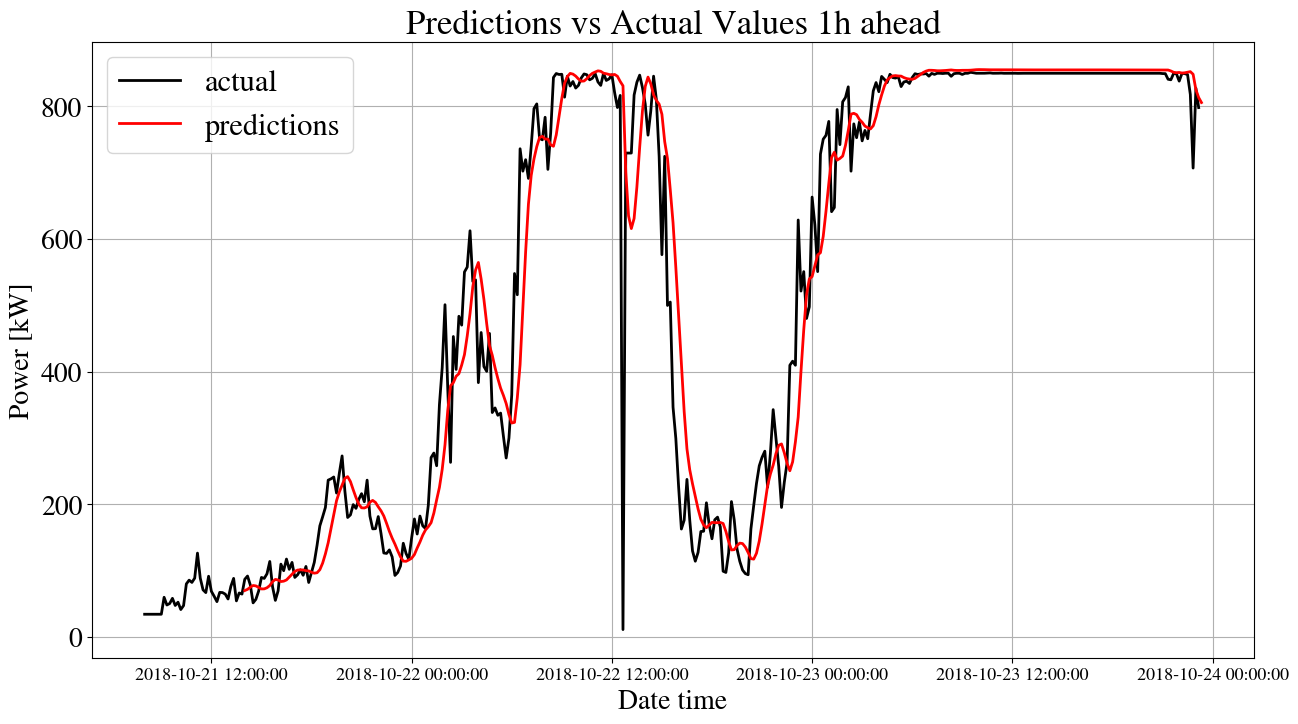

In [300]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# plot the predictions

# Set the formatter
date_format = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')  # adjust the format as needed

plt.figure(figsize=(15,8))
plt.plot(df_test_Y[150:144*4], 'k', label='actual', linewidth=2)
plt.plot(df_predictions[150:144*4],'-r', label='predictions', linewidth=2)
plt.grid(True)

# Set the formatter
plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Date time', fontsize=20)
plt.ylabel('Power [kW]', fontsize=20)

# make the legend larger
plt.legend(fontsize=22)

#make larger the tick labels
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)

plt.title('Predictions vs Actual Values 1h ahead', fontsize=25)


plt.show()


## PERCENTAGE ERROR

### Procees the predictions and test_y to be able to calculate the percentage error

In [263]:
# Remove the first n_lag values from both predictions and test_Y
date = Y_test.index[n_lag:]
predictions = predictions[n_lag:]
test_Y = test_Y[n_lag:]

In [264]:
percentage_error = ((predictions - test_Y)/test_Y)*100

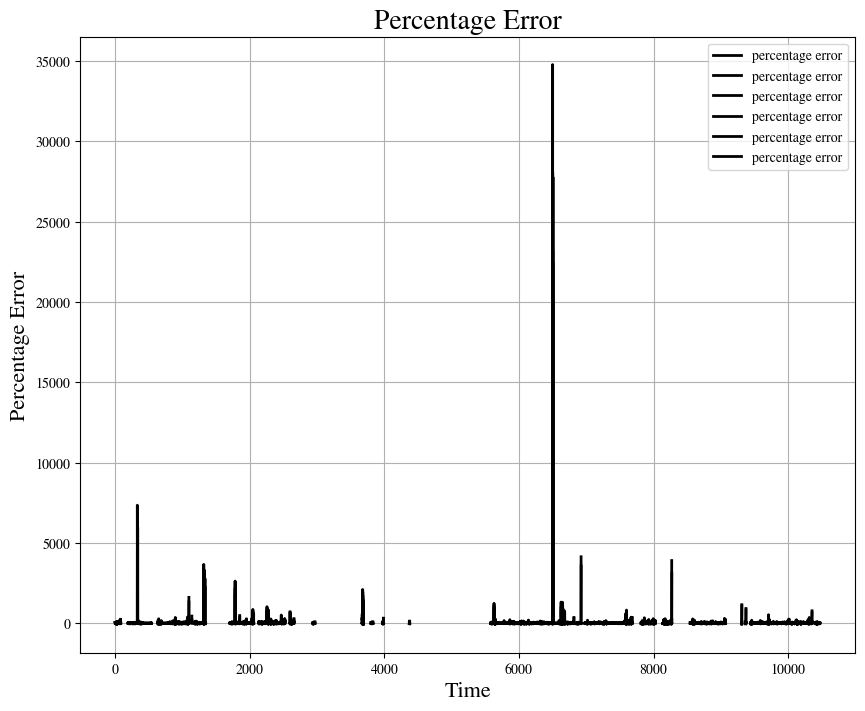

In [265]:


# plot the percentage error
plt.figure(figsize=(10,8))

plt.plot(percentage_error, 'k', label='percentage error', linewidth=2)
plt.grid(True)

plt.title('Percentage Error', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Percentage Error', fontsize=16)

plt.legend()

C:\Users\enriq\AppData\Local\Temp\ipykernel_32724\4244188859.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(percentage_error, bins=30, kde=True, color='k', label='Percentage Error')


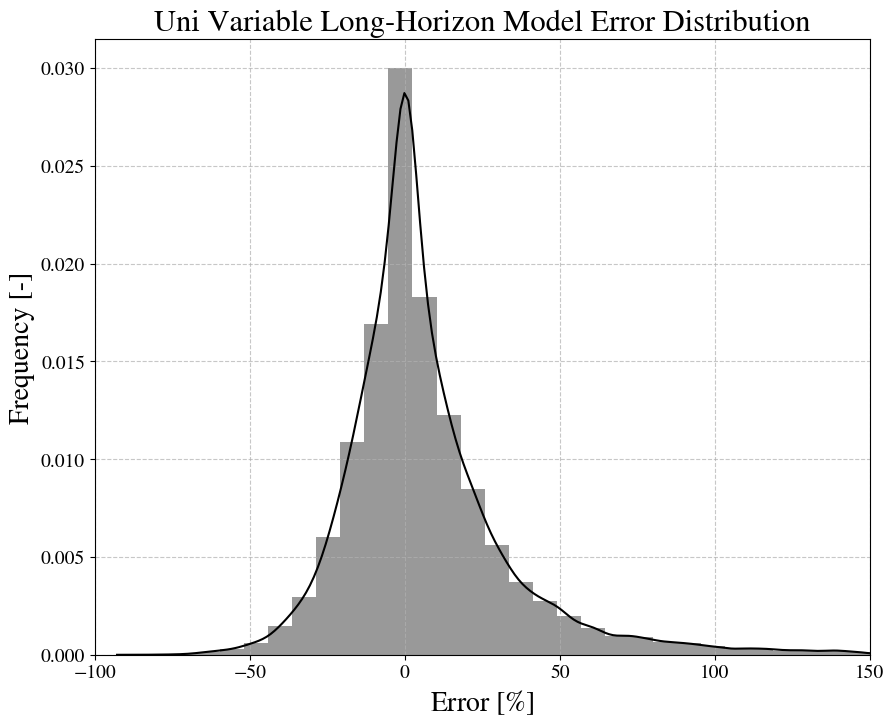

In [266]:
# filter values greater than 300%
percentage_error = percentage_error[percentage_error < 150]
# plot the distribution of the percentage error
plt.figure(figsize=(10, 8))

# Plot the distribution with a label for the legend
sns.distplot(percentage_error, bins=30, kde=True, color='k', label='Percentage Error')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Uni Variable Long-Horizon Model Error Distribution', fontsize=22)
plt.xlabel('Error [$\%$]', fontsize=20)
plt.ylabel('Frequency [-]', fontsize=20)

# Set x-axis limits
plt.xlim(-100, 150)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# Show the plot
plt.show()


In [267]:
# get the mean and standard deviation of the percentage error
mean_percentage_error = np.mean(percentage_error)
std_percentage_error = np.std(percentage_error)

print('mean_percentage_error:', mean_percentage_error)
print('std_percentage_error:', std_percentage_error)

mean_percentage_error: 6.397533056419015
std_percentage_error: 26.558092716252048
